In [1]:
%run 00_analysis_config.ipynb

Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

import lsfit
reload(lsfit)
from lsfit import *

import include_modules_root as rt
import Kalman_tom

In [3]:
files=glob.glob(f"{DATA_DIR}/muon_100_GeV/*/*/stat_seedmod.root",)
print(files)
file_prefix=os.path.dirname(files[0])
tree_name="integral_tree"

filename = files[0]
# filename_ref = os.path.dirname(filename)+"/stat_seedmod.root"

['/project/def-mdiamond/tomren/mathusla/data/fit_study_6layer/muon_100_GeV/20230503/170343/stat_seedmod.root']


In [4]:
# 2. Open file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)


['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'G4KLong_code', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0', 'Track_k_m_y0', 'Track_k_m_z0', 'Track_k_m_t0',

In [15]:
Tree.GetEntry(2)
print(Tree.Digi_pdg_id)

{ 13, 13, 13, 13, 13, 13, 13, 13, 11 }


## Reproducing the pattern recognition algorithm in python

### 1. Problem with the current seeding algorithm

The current seeding algorithm is scoring all hit pairs with score $|ds^2| = |dr^2 - c^2dt^2|$, in which $dr = |(x_2-x_1,y_2-y_1,z_2-z_1)|$. The smaller $|ds^2|$ is, the higher priority the seed get. The purpose of this value is to select pair of hits that are consistent with a particle traveling at speed of light $c$.

However, this gauge is bad because the uncertainty of $|ds^2|$ heavily depends on the distance of the two hits, making it prefers hits that are in the adjacent layers. We should be directly select on the velocity difference from the speed of light: $|v-c|=||dr|/dt-c|=|\sqrt{(x_2-x_1)^2+(y_2-y_1)^2+(z_2-z_1)^2}/|t_2-t_1| - c|$. Seed with smaller $|v-c|$ should have higher priority.

Additionaly, we prefer hits that are 3 layers apart. We define the absolute layer difference as $|LayerIndex_1-LayerIndex_2|$, in which LayerIndex is the index of the layer counting from the bottom floor layer (layer0). There are two floor layers (0,1), two middle layers (2,3) and 6 top layers (4,5,6,7,8,9).

We define a new score combining the velocity information and layer information together: 

$s = |v-c| + ||LayerIndex_1-LayerIndex_2|-3|\cdot3000$

$v$ and $c$ have units of [cm/ns], c=30[cm/ns], so |v-c| will roughly be in the range of O(10) depending on the uncertainty of v (the next subsections shows that uncertainty on v is O(1) to O(10)). ||LayerIndex_1-LayerIndex_2|-3| reaches the minimum value of 0 when two hits are 3 layers apart, and is greater than 0 when not. The factor of 3000 guarantees that the layer information is the dominating factor. Together, score $s$ will prioritize hits that are 3 layers apart. Among thoses hits that have same amount of layer gaps, the ones that are most consistent with speed of light is used first. 


#### Uncertaint of $v-c$
$\sigma_v^2 = (\frac{1}{vdt^2})^2(dx^2(\sigma_{x1}^2+\sigma_{x2}^2)+dy^2(\sigma_{y1}^2+\sigma_{y2}^2)+dz^2(\sigma_{z1}^2+\sigma_{z2}^2)) + (\frac{v}{dt})^2(\sigma_{t1}^2+\sigma_{t2}^2)$

Suppose two hits are on layers with different directions, $\sigma_{y1}^2+\sigma_{y2}^2 = \sigma_{x1}^2+\sigma_{x2}^2 = 13^2+1.3^2=170$, $\sigma_{z1}^2+\sigma_{z2}^2 = 2*(2/\sqrt{12})^2=0.67$, $\sigma_{t1}^2+\sigma_{t2}^2 = 2*1=2$, $\sigma_v^2$ reduces to $(\frac{1}{vdt^2})^2(170dx^2+170dy^2+0.67dz^2)+(\frac{v}{dt})^2*2$. The fractional uncertainty would be

$\frac{\sigma_v}{v} = \sqrt{(\frac{1}{v^2dt^2})^2(170dx^2+170dy^2+0.67dz^2)+(\frac{1}{dt})^2*2}$

For two hits from layer 2 and 5, assuming that they are along the verticle direction, so dx=dy=0, dz=700[cm], dt=700/30=23.3[ns]

$\frac{\sigma_v}{v} = 6\%$, ${\sigma_v}\sim 1.8$ [cm/ns]

For two hits from layer 2 and 3, assuming that they are along the verticle direction, so dx=dy=0, dz=100[cm], dt=100/30=33.3[ns]

$\frac{\sigma_v}{v} = 40\%$, ${\sigma_v}\sim 12$ [cm/ns]

In [20]:
dz=100
v=30
dt=dz/v
dx=10

dz=700
v=30
dt=dz/v
dx=10

sqrt(1/(30**2*dt**2)**2*(170*dx**2 + 0.67*dz**2) + 2/(dt**2))*v

1.8186304695217919

In [4]:
class kf_find():
    def __init__(self,seed, hits, seed0_idx,  hits_used_mask=None, chi2_add=20, chi2_pval_drop=0.99):
        self.seed = np.array(seed)
        self.hits = np.array(hits)
        
        # Setup a Kalman filter 
        self.X0,self.P0 = self.init_state(seed)
        self.M0=self.X0[:3]
        # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
        self.H = np.array(\
            [[1,0,0,0,0,0],
             [0,1,0,0,0,0],
             [0,0,1,0,0,0]])
        # Initial propogation covariacne (Q)
        self.Q=0        
        # Kalman Filter Object
        self.kf = Kalman_tom.KalmanFilter(self.X0,self.P0,self.M0, H=self.H)
        
        # Get info of hits
        self.hits_layer = np.array([cut.in_layer(hit.y) for hit in hits])
        self.hits_time = np.array([hit.t for hit in hits])
        self.seeds_layer = np.array([cut.in_layer(hit.y) for hit in seed])
        self.seeds_time = np.array([hit.t for hit in seed])        
        self.UP=True
        self.DOWN=False
        self.seed_direction = self.UP if (self.seeds_layer[1]-self.seeds_layer[0])/(self.seeds_time[1]-self.seeds_time[0])>0 else self.DOWN
        self.seed0_idx = seed0_idx
        self.seed0_layer = self.hits_layer[seed0_idx]
        
        if hits_used_mask is None:
            hits_used_mask=np.zeros(len(hits),dtype=bool)
        self.hits_used_mask=hits_used_mask
            
        # Other status variables
        self.TOP_LAYER = np.max(self.hits_layer)
        self.BOTTOM_LAYER = np.min(self.hits_layer)
        self.CURREN_LAYER = 0;
        self.MINIMUM_HITS = 4;
        self.FOUND_HITS_IDX = [seed0_idx];        
        self.SUCCEED = False;
        self.chi2_add = chi2_add
        
        
    
    def init_state(self, hits):
        i=0;        j=1;
        dt=hits[j].t-hits[i].t
        dx=hits[j].x-hits[i].x
        dy=hits[j].y-hits[i].y
        dz=hits[j].z-hits[i].z

        # Initial State Vector: X0
        X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])

        # Initial Variance P0
        J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
            [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
            [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
            [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
            [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
            [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
        # Initial Variance P0
        err0=np.diag([hits[i].x_uncertainty,hits[i].t_uncertainty,hits[i].z_uncertainty,hits[i].y_uncertainty,
                     hits[j].x_uncertainty,hits[j].t_uncertainty,hits[j].z_uncertainty,hits[j].y_uncertainty])**2
        P0=J.dot(err0).dot(J.T)

        return X0, P0


    def add_measurement(self, hit, X_current, dy):
        vy_current = X_current[4]
        dt_next = dy/vy_current
        Y = np.array([hit.x,hit.t,hit.z])
        R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
        A = np.array([[1, 0, 0, dt_next, 0, 0],
                      [0, 1, 0, 0, dt_next/vy_current, 0],
                      [0, 0, 1, 0, 0, dt_next],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        return  Y,R,A
    
    def add_measurement_corrected(self, hit, X_current, dy):
        """
        Change the definition of A to the jacobian of f
        return f as well
        """
        vx_current = X_current[3]
        vy_current = X_current[4]
        vz_current = X_current[5]
        dt_next = dy/vy_current
        Y = np.array([hit.x,hit.t,hit.z])
        R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
        A = np.array([[1, 0, 0, dt_next, -dy*vx_current/vy_current**2, 0],
                      [0, 1, 0, 0, -dt_next/vy_current, 0],
                      [0, 0, 1, 0, -dy*vz_current/vy_current**2, dt_next],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        f = lambda state: f_model(*state, dy)
        return  Y,R,A, f
    
    def undo_kf_step(self, kf):
        del kf.X_predicted[-1]
        del kf.A_s[-1]
        del kf.Q_s[-1]
        del kf.P_predicted[-1]
        del kf.X_filtered[-1]
        del kf.P_filtered[-1]
        del kf.K_s[-1]
        del kf.M_measurements[-1]
        return
    
    
    def find_all(self):
        y_pre = self.seed[0].y
        
        # For each layer, pick one hit that matches the seed the best
        chi2_forward=[]
        for layer in np.arange(self.BOTTOM_LAYER, self.TOP_LAYER+1):
            # Bypass the layer of the seed
            if layer==self.seed0_layer:
                continue
            
            # Examine the chi2 by trying to add each hit to the KF
            mask_hit = ~self.hits_used_mask & (self.hits_layer==layer)
            if sum(mask_hit)==0: # continue if there is no hits on this layer
                continue
            hits_in_use = self.hits[mask_hit]
            hits_in_use_idx = np.arange(len(hits))[mask_hit]
            chi2_list = []
            for hit in hits_in_use:
                # Add hit and filter
                dy = hit.y-y_pre
                X_previous = self.kf.X_filtered[-1]
                M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
                X_predicted, P_predicted = self.kf.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
                X_filtered, P_filtered = self.kf.filter_forward(M_current,R)

                # calculate the increment in the chi squared
                Y = [hit.x, hit.t, hit.z]
                H = self.H
                err_metric_p = R + H @ P_filtered @ H.transpose();
                chi_plus = (Y - H@X_filtered).transpose() @ np.linalg.inv(err_metric_p) @ (Y - H @ X_filtered);
                chi2_list.append(chi_plus)
                
                # Revert the KF by one step
                self.undo_kf_step(self.kf)
                
            #print(layer,chi2_list)

            # add the hit if chi2 is smaller than the threshold
            if np.min(chi2_list)<self.chi2_add:
                # add the good hit back to KF
                hit = hits_in_use[np.argmin(chi2_list)]
                dy = hit.y-y_pre
                X_previous = self.kf.X_filtered[-1]
                M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
                X_predicted, P_predicted = self.kf.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
                self.kf.filter_forward(M_current,R)  
                
                # add hit to USED list
                self.FOUND_HITS_IDX.append(hits_in_use_idx[np.argmin(chi2_list)])
                
                # Update the Y_PRE
                y_pre = hit.y
                
                # Update chi2
                chi2_forward.append(np.min(chi2_list))
                
                # print(layer,self.FOUND_HITS_IDX)
#                 print(self.kf.X_filtered)
            else:
                continue
                    
        # Run the filter on all found hits again
        # , and do backward smoothing to drop bad hit    
        self.SUCCEED2 = True
        if len(self.FOUND_HITS_IDX)>=self.MINIMUM_HITS:
            dropping_mask=np.zeros(len(self.FOUND_HITS_IDX),dtype=bool)
            
            # Forward
            hits_filter = hits[self.FOUND_HITS_IDX]
            # --- need a new initial state X0 using the first and last hit:
            X0_new, P0_new = self.init_state(hits_filter[[0,-1]])
            M0_new = X0_new[:3]
            hit=hits_filter[0]
            R0_new = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
            self.kf2 = Kalman_tom.KalmanFilter(X0_new,P0_new,M0_new, H=self.H, R0=R0_new)
            # Filter forward
            for i in range(1,len(self.FOUND_HITS_IDX)):
                hit = hits[i]
                dy = hits[i].y-hits[i-1].y
                X_previous = self.kf2.X_filtered[-1]
                M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
                X_predicted, P_predicted = self.kf2.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
                X_filtered, P_filtered = self.kf2.filter_forward(M_current,R)   
                # calculate the increment in the chi squared
                Y = [hit.x, hit.t, hit.z]
                H = self.H
                err_metric_p = R + H @ P_filtered @ H.transpose();
                chi_plus = (Y - H@X_filtered).transpose() @ np.linalg.inv(err_metric_p) @ (Y - H @ X_filtered);
                print("chi+",chi_plus)
                if chi_plus>self.chi2_add:
                    self.SUCCEED2 = False
            
            # Backward
            self.kf2._init_smooth()
            while self.kf2.CURRENT_STEP>=0:
                Y = self.kf2.M_measurements[self.kf2.CURRENT_STEP]
                R = self.kf2.R_s[self.kf2.CURRENT_STEP]
                # Run smoothing
                X_smoothed, P_smoothed = self.kf2._smooth_step()
                # Calculate chi2
                H = self.H
                X_smoothed = self.kf2.X_smoothed[0]
                P_smoothed = self.kf2.P_smoothed[0]
                chi_plus_s = (Y - H @ X_smoothed).transpose() @ np.abs(np.linalg.inv((R - H @ P_smoothed @ H.transpose()))) @ (Y - H @ X_smoothed)
                print(chi_plus_s)
                
                
            
        if len(self.FOUND_HITS_IDX)>=self.MINIMUM_HITS and self.SUCCEED2:
            self.SUCCEED = True
        else:
            self.SUCCEED = False
        
        return self.SUCCEED


In [5]:
def sort_hits(hits):
    times = []
    for hit in hits:
        times.append(hit.t)
    hits_sorted = np.array(hits)[np.argsort(times)]
    return hits_sorted

def seed_bilayer(hits, hits_used_mask):
    hits_inds = np.arange(len(hits))
    hits_layer = np.array([cut.in_layer(hit.y) for hit in hits])
    hits_layer_unused = np.unique(hits_layer[~hits_used_mask])
    
    hits_layer_pairs = []
    seeds = []
    seeds01_idx = []
    seeds_dy = []
    seeds_time0 = []
    
    # find layers with the same kind of directions
    for i in range(len(hits_layer_unused)):
        for j in range(i+1, len(hits_layer_unused)):
            if i%2!=j%2:
                hits_layer_pairs.append([hits_layer_unused[i], hits_layer_unused[j]])
    
    # Find all pairs of hits from the two layers
    for layer_pair in hits_layer_pairs:
        for i_hit0 in np.flatnonzero((hits_layer==layer_pair[0])&~hits_used_mask):
            for i_hit1 in np.flatnonzero((hits_layer==layer_pair[1])&~hits_used_mask):
                hit0 = hits[i_hit0]
                hit1 = hits[i_hit1]
                if hit0.t<hit1.t:
                    seeds.append([hit0, hit1])
                    seeds01_idx.append([i_hit0,i_hit1])
                    seeds_time0.append(hit0.t)
                else:
                    seeds.append([hit1, hit0])
                    seeds01_idx.append([i_hit1,i_hit0])
                    seeds_time0.append(hit1.t)
                seeds_dy.append(np.abs(hit1.y - hit0.y))
                    
    # Sort hits based on dy. Larger dy--> better accuracy
    # For each dy, sort by time. The one comes earlier has higher priority
    seeds_dy_unique = np.sort(np.unique(seeds_dy))[::-1]
    seeds_time0=np.array(seeds_time0)
    seeds=np.array(seeds)
    seeds01_idx=np.array(seeds01_idx)
    
    seeds_sorted=[]
    seeds01_idx_sorted=[]
    for dy in seeds_dy_unique:
        mask = seeds_dy==dy
        seeds_time0_sub = seeds_time0[mask]
        seeds_sub = seeds[mask][np.argsort(seeds_time0_sub)]
        seeds01_idx_sub = seeds01_idx[mask][np.argsort(seeds_time0_sub)]
        for i in range(len(seeds_sub)):
            seeds_sorted.append(seeds_sub[i])
            seeds01_idx_sorted.append(seeds01_idx_sub[i])
        
#     seeds = np.array(seeds)[np.argsort(seeds_dy)[::-1]]
#     seeds0_idx = np.array(seeds0_idx)[np.argsort(seeds_dy)[::-1]]
    
    return np.array(seeds_sorted), np.array(seeds01_idx_sorted)

In [6]:
# for hit in hits:
#     print(hit.y, hit.t)

In [7]:
def f_model(x,t,z,vx,vy,vz, dy):
    xn = x + dy*vx/vy
    tn = t + dy* 1/vy
    zn = z + dy*vz/vy
    return (xn, tn, zn, vx, vy, vz)

## Check chi2 distribution with different seeds

In [8]:
def get_all_chi2(self):
    y_pre = self.seed[0].y

    # For each layer, pick one hit that matches the seed the best
    chi2_forward=[]
    for layer in np.arange(self.BOTTOM_LAYER, self.TOP_LAYER+1):
        # Bypass the layer of the seed
        if layer==self.seed0_layer:
            continue

        # Examine the chi2 by trying to add each hit to the KF
        mask_hit = ~self.hits_used_mask & (self.hits_layer==layer)
        if sum(mask_hit)==0: # continue if there is no hits on this layer
            continue
        hits_in_use = self.hits[mask_hit]
        hits_in_use_idx = np.arange(len(hits))[mask_hit]
        chi2_list = []
        for hit in hits_in_use:
            # Add hit and filter
            dy = hit.y-y_pre
            X_previous = self.kf.X_filtered[-1]
            M_current,R,A,f = self.add_measurement_corrected(hit, X_previous, dy)
            X_predicted, P_predicted = self.kf.predict_foward(A,self.Q,f=f)# self.kf.predict_foward(A,self.Q)
            X_filtered, P_filtered = self.kf.filter_forward(M_current,R)

            # calculate the increment in the chi squared
            Y = [hit.x, hit.t, hit.z]
            H = self.H
            err_metric_p = R + H @ P_filtered @ H.transpose();
            chi_plus = (Y - H@X_filtered).transpose() @ np.linalg.inv(err_metric_p) @ (Y - H @ X_filtered);
            chi2_list.append(chi_plus)
            
            y_pre = hit.y
            
            chi2_forward.append(chi_plus)
    return chi2_forward

### Using the first and the second hit

In [9]:
ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())   

nhits=[]
for i in range(nevents):
    ev.Tree.GetEntry(i)
    nhits.append(ev.Tree.Digi_x.size())
    
nhits = np.array(nhits)

In [28]:
mask_7hits = nhits==8
# mask_7hits = res_ls["ndigi_total"]==7


ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())   
chi2_forward = []

# for idx,i_event in enumerate(range()):
# for i_event in range(5,7):
for i_event in tqdm(range(nevents)):
    
    # If 7 hits:
    if mask_7hits[i_event]:
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)

        seed=[hits[0],hits[1]]
        seed0_idx=0
        u_kf_find = kf_find(seed,hits,seed0_idx, hits_used_mask=None, chi2_add=10)
        chi2 = get_all_chi2(u_kf_find)
        chi2_forward.append(chi2)
        
chi2_forward=np.array(chi2_forward)        

100%|██████████| 40000/40000 [00:49<00:00, 800.33it/s]


In [29]:
chi2_length=[]
for i in chi2_forward:
    chi2_length.append(len(i))
chi2_length = np.array(chi2_length)

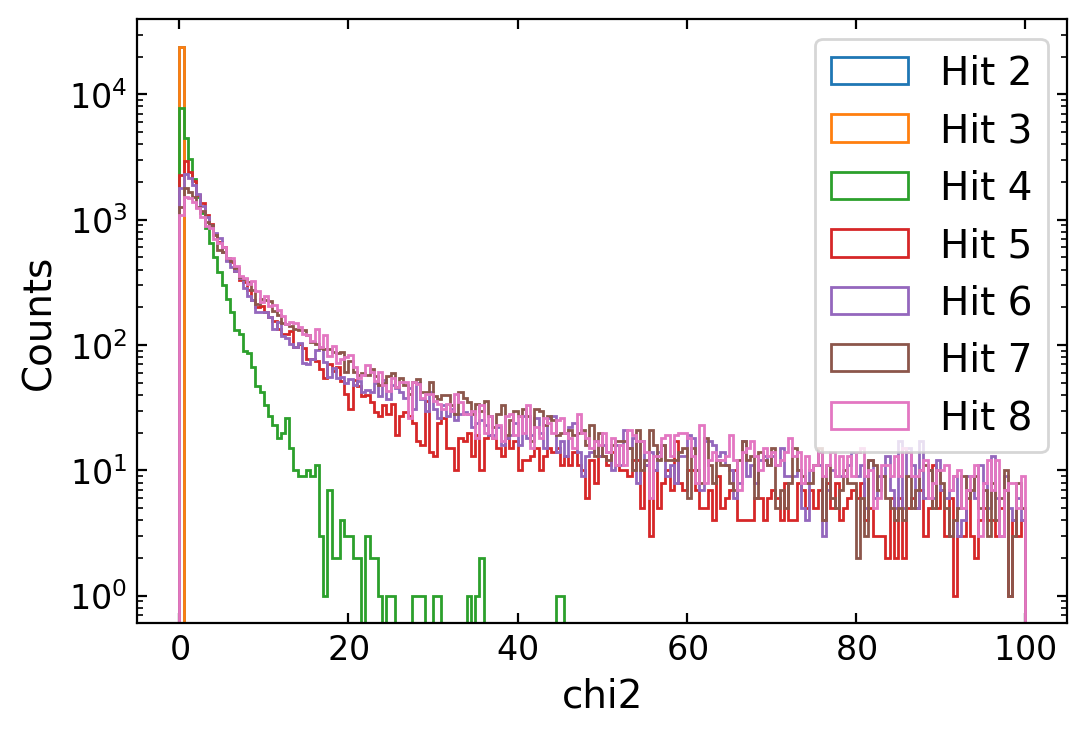

In [30]:
for i in range(7):
    hist(chi2_forward[:,i], bins=200,range=(0,100),histtype="step",label=f"Hit {i+2}")
legend()
xlabel("chi2")
ylabel("Counts")
yscale("log")
show()

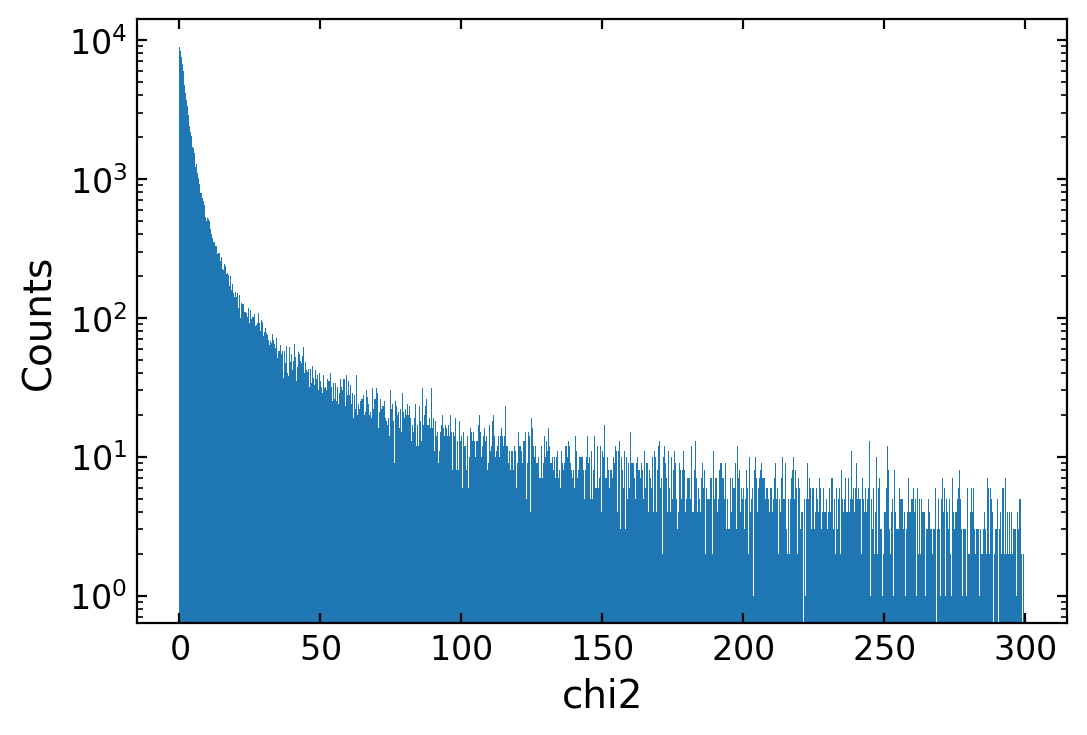

278.40720000000005


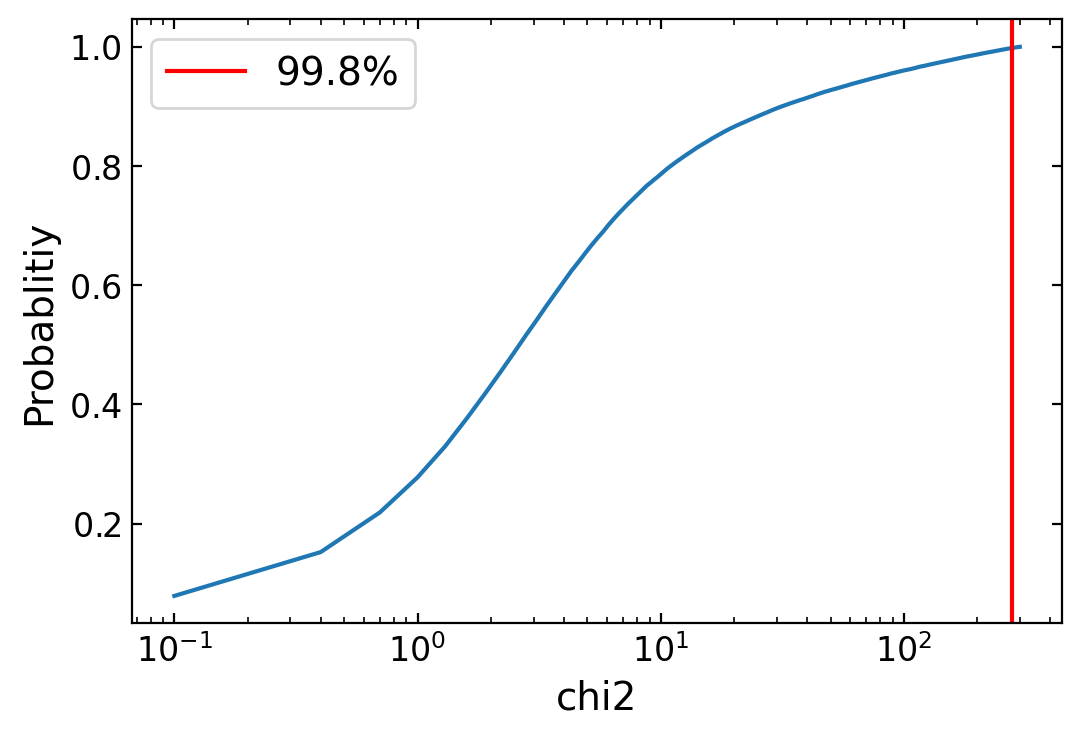

In [31]:
n,ibins,p = hist(util.Utils.flatten1d(chi2_forward), bins=1000,log=1,range=(0.1,300));
xlabel("chi2")
ylabel("Counts")
show()

cdf=np.cumsum(n)/np.sum(n)
plot(ibins[:-1],cdf)
xscale("log")
xlabel("chi2")
ylabel("Probablitiy")
print(ibins[np.argmax(cdf>0.998)])
axvline(ibins[np.argmax(cdf>0.998)],color="r",label="99.8%")
legend()

### Using the first and the fourth hit

In [22]:
mask_7hits = nhits==8

ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())   
chi2_forward = []

# for idx,i_event in enumerate(range()):
# for i_event in range(5,7):
for i_event in tqdm(range(nevents)):
    
    # If 7 hits:
    if mask_7hits[i_event]:
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)

        seed=[hits[0],hits[3]]
        seed0_idx=0
        u_kf_find = kf_find(seed,hits,seed0_idx, hits_used_mask=None, chi2_add=10)
        chi2 = get_all_chi2(u_kf_find)
        chi2_forward.append(chi2)
        
chi2_forward=np.array(chi2_forward)

100%|██████████| 40000/40000 [00:49<00:00, 808.47it/s]


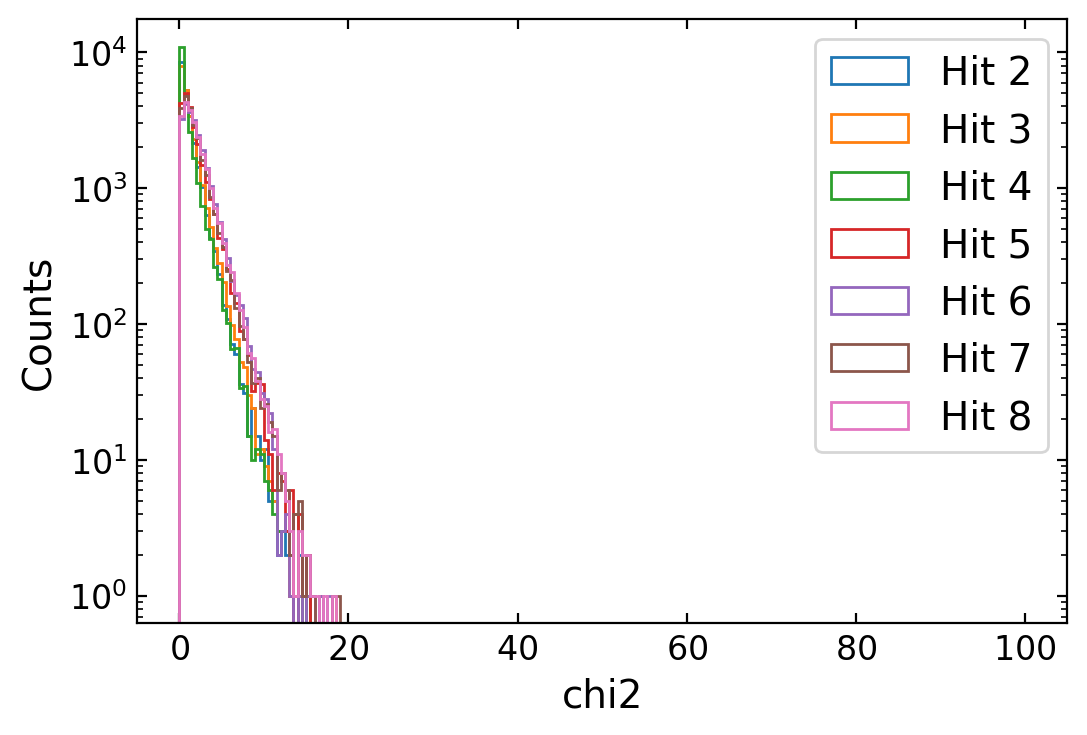

In [25]:
for i in range(7):
    hist(chi2_forward[:,i], bins=200,range=(0,100),histtype="step",label=f"Hit {i+2}")
legend()
xlabel("chi2")
ylabel("Counts")
yscale("log")
show()

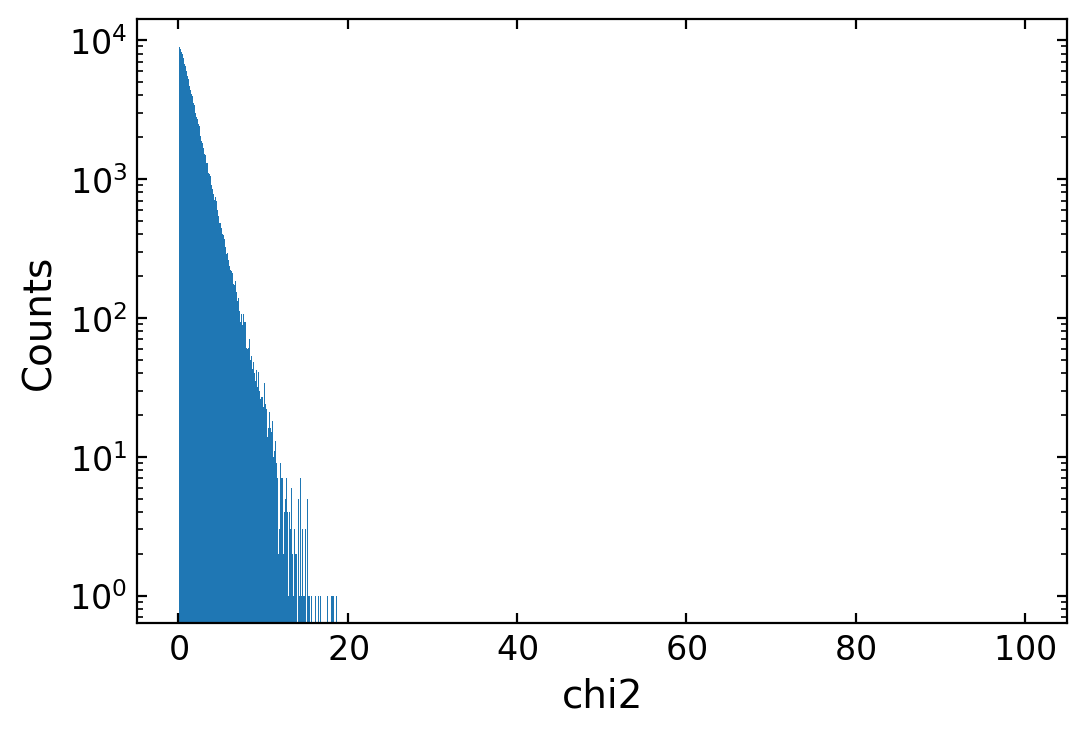

10.3897


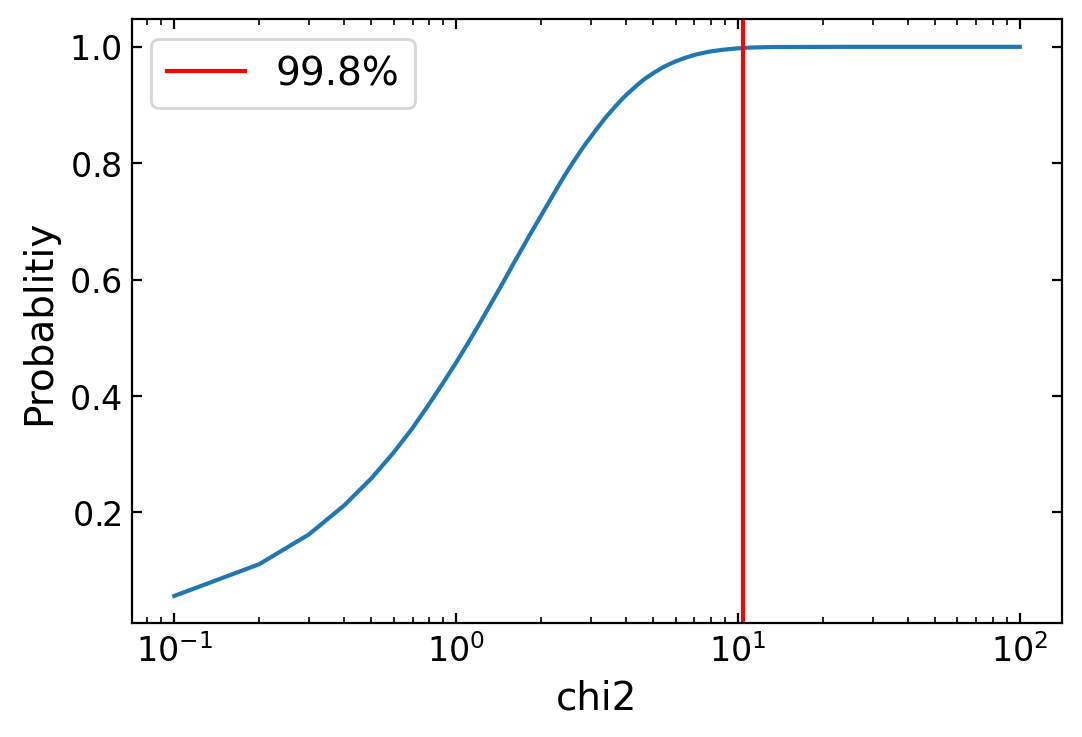

In [27]:
n,ibins,p = hist(util.Utils.flatten1d(chi2_forward), bins=1000,log=1,range=(0.1,100));
xlabel("chi2")
ylabel("Counts")
show()

cdf=np.cumsum(n)/np.sum(n)
plot(ibins[:-1],cdf)
xscale("log")
xlabel("chi2")
ylabel("Probablitiy")
print(ibins[np.argmax(cdf>0.998)])
axvline(ibins[np.argmax(cdf>0.998)],color="r",label="99.8%")
legend()

---
Please ignore the content below
## Make some improvement?

### What about Hough transform?

--Doesn't work. We have too few points with large uncertainty

**We need the Kalman filter or Least square which have proper statistical treatment on uncertainty**

In [173]:
def hough_line(xs, ys, y_sigmas=None, sigma_steps=5):
    # Rho and Theta ranges
    x0=np.mean(xs)
    y0=np.mean(ys)
    xs=np.array(xs)-x0
    ys=np.array(ys)-y0
    distance_max = np.max([np.sqrt(x**2+y**2) for x,y in zip(xs,ys)])
    # Steps
    theta_steps = 180
    rho_steps = 180
    thetas = np.deg2rad(np.linspace(0, 180.0, theta_steps))
    rhos = np.linspace(-distance_max, distance_max, rho_steps)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((rho_steps, theta_steps))
    
    # Get the weight of each sigma step
    sigmas = np.linspace(-2,2,sigma_steps*2)
    sigma_weight = scipy.stats.norm.cdf(sigmas) 
    sigma_weights = sigma_weight[1:]-sigma_weight[:-1]
    sigma_centers =0.5*(sigmas[1:]+sigmas[:-1])

    # Vote in the hough accumulator
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        for t_idx in range(theta_steps):
            if y_sigmas is None:
                # Calculate rho. rho_steps is added for a positive index
                rho = x * cos_t[t_idx] + y * sin_t[t_idx]
                rho_idx = np.argmax(rhos>rho)
                accumulator[rho_idx, t_idx] += 1
            else:
                for j in range(len(sigma_centers)):
                    delta_y = y_sigmas[i]*sigma_centers[j]
                    rho = x * cos_t[t_idx] + (y+delta_y) * sin_t[t_idx]
                    rho_idx = np.argmax(rhos>rho)
                    accumulator[rho_idx, t_idx] += sigma_weights[j]                  
                
    return accumulator, thetas, rhos

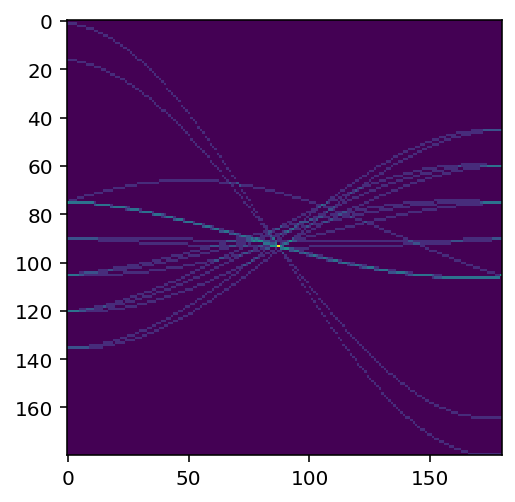

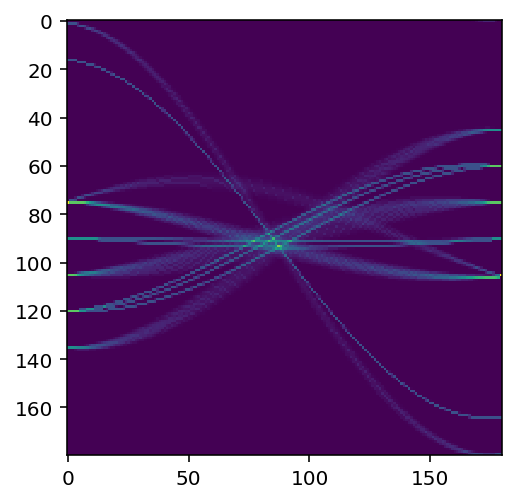

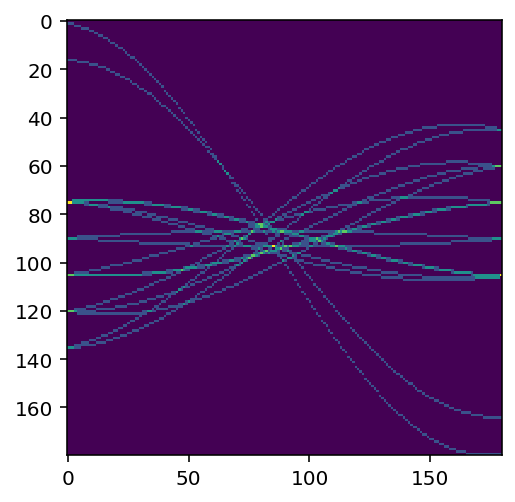

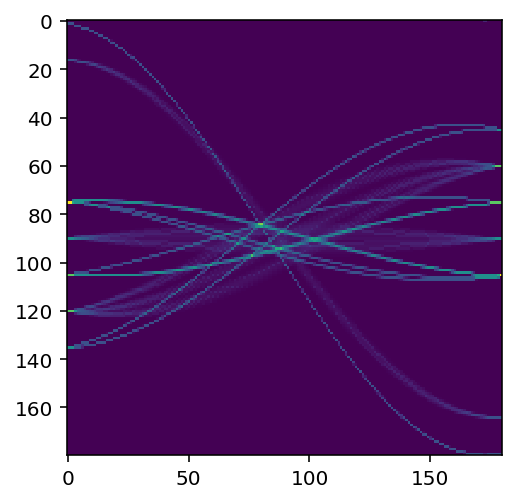

In [174]:
xs = [hit.y for hit in hits]
ys = [hit.x for hit in hits]
accumulator, thetas, rhos =  hough_line(xs, ys)
plt.imshow(accumulator)
plt.show()

y_error = [hit.x_uncertainty for hit in hits]
accumulator2, thetas, rhos =  hough_line(xs, ys, y_sigmas=y_error)
plt.imshow(accumulator2)
plt.show()



xs = [hit.y for hit in hits]
ys = [hit.z for hit in hits]
accumulator, thetas, rhos =  hough_line(xs, ys)
plt.imshow(accumulator)
plt.show()

y_error = [hit.z_uncertainty for hit in hits]
accumulator2, thetas, rhos =  hough_line(xs, ys, y_sigmas=y_error)
plt.imshow(accumulator2)
plt.show()

---

In [35]:
filename=f"{file_prefix}/stat_seedmod.root"
tree_name="integral_tree"
ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())
cut=cutflow.sample_space("")



# for i_event in tqdm(range(nevents)):
nfailed_seeding=0
seeds_all=[]
seeds_perevent=[]
for i_event in tqdm(range(nevents)):
    ev.EventNumber=i_event
    ev.Tree.GetEntry(i_event)
    hits = get_digi_hits(ev)
    
    seeds=Seed(hits,cut=5)
    seeds_all.append(seeds)
    seeds_nc=Seed(hits,cut=None)
    seeds_perevent.append(seeds_nc)    
    if len(seeds)==0:
        nfailed_seeding+=1
print(nfailed_seeding,nevents)
sees_all=np.array(sees_all)

100%|██████████| 40000/40000 [00:19<00:00, 2100.02it/s]


369 40000


At |ds|<5
 Event with 0 seeds 369.0 out of 40000
At |ds|<7
 Event with 0 seeds 50.0 out of 40000


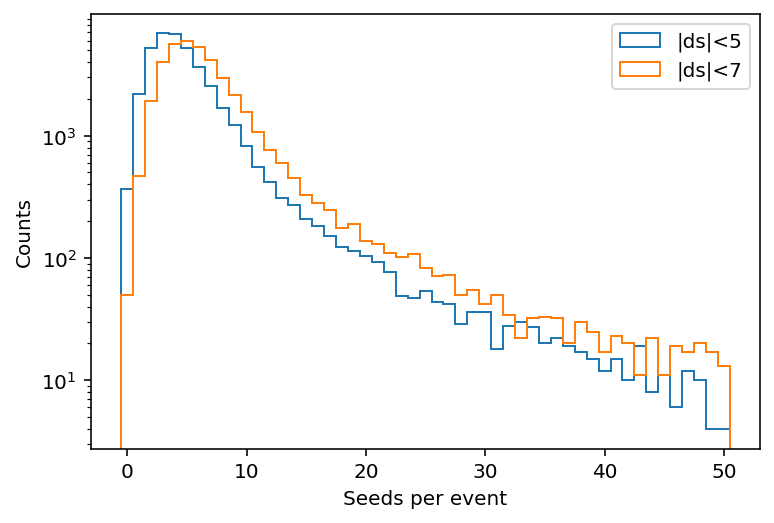

In [56]:
seed_per_event=[]
seed_per_event_cut6=[]

for seeds in seeds_all:
    seed_per_event.append(len(seeds))
for seeds in seeds_perevent:
    n=0
    for seed in seeds:
        if seed[-1]<7:
            n+=1
    seed_per_event_cut6.append(n)
n,ibins,p=plt.hist(seed_per_event,bins=np.linspace(-0.5,50.5,52),log=1,histtype="step",label="|ds|<5");
n2,ibins,p=plt.hist(seed_per_event_cut6,bins=np.linspace(-0.5,50.5,52),log=1,histtype="step",label="|ds|<7");
plt.xlabel("Seeds per event")
plt.ylabel("Counts")
plt.legend()
print("At |ds|<5")
print(" Event with 0 seeds",n[0],"out of",len(seed_per_event))
print("At |ds|<7")
print(" Event with 0 seeds",n2[0],"out of",len(seed_per_event))